In [1]:
# Test MPC

# Standard imports for SCP via JAX and CVXPY
import numpy as np # CVXPY uses numpy
import cvxpy as cvx # For Convex Optimization
from cvxpy.constraints import constraint
import jax # For computing gradients and JIT
import jax.numpy as jnp
from tqdm import tqdm # For progress bars
from functools import partial # For helping JAX

# Assessment
import time
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy.optimize

import dynamics as dn
import control as ct

## Common Parameters

In [2]:
import pykep

np.random.seed(1)

# SPACECRAFT PARAMETERS
C_D = 1.5 # Dimensionless
C_SRP = 1.5 # Dimensionless

A = 1.0   # m^2
MASS_SAT = 100   # kg

GAMMA_SRP = C_SRP * A / MASS_SAT
GAMMA_DRAG = C_D * A / MASS_SAT

PSI = 0    # thermal oscillation

R_EARTH = 6378
MU_EARTH_KM = pykep.MU_EARTH * 1e-9
EARTH_TO_SUN_VEC = dn.compute_earth_to_sun()


## Spacecraft Initial States

In [3]:
# Initial condition of reference orbit
h = 300  # km  height for perigee
e = 0.001
a = (R_EARTH + h) / (1 - e)
i = 0.6
W = 0
w = 0
E = 0

# orbital period
T = 2 * jnp.pi * jnp.sqrt(a**3/MU_EARTH_KM)

# compute orbit elements
oe_chief = np.array([a, e, i, W, w, E])
r0_chief, v0_chief = pykep.core.par2ic(oe_chief, MU_EARTH_KM)

# convert to JAX array
x0_chief_eci = jnp.array(np.hstack([r0_chief, v0_chief]))

# Initial  States
s0_rel_chief = jnp.hstack([dn.eci_to_lvlh(x0_chief_eci, x0_chief_eci)])
print(f"Should be uniformly zero = {s0_rel_chief}")

Should be uniformly zero = [0. 0. 0. 0. 0. 0.]


## Time Propagation Settings

In [4]:
# Propagation time settings
dt = 0.1
tspan_quarter_periods = np.arange(0, 0.1 * T, dt)   # propagation step
print(f"Tspan size: {tspan_quarter_periods.size}")

Tspan size: 5440


## JIT Dynamics Functions

In [5]:
# JIT the dynamics functions
t = 0  # we can assume this because there is no change in the parameters
fd_absolute = jax.jit(ct.discretize(ct.absolute_dynamics, dt))

x_chief_eci_traj = ct.propagate_absolute_from_control(x0_chief_eci, ct.zero_control, tspan_quarter_periods, fd_absolute)

interp_abs_chief_jit = jax.jit(ct.interp_fixed(tspan_quarter_periods, x_chief_eci_traj[:, :-1]))
fd_relative_4T = jax.jit(ct.discretize(ct.relative_dynamics, dt, params=(GAMMA_SRP, GAMMA_DRAG, PSI), state_eci_ref_func=interp_abs_chief_jit))
fd_relative_4T_back = jax.jit(ct.discretize(ct.relative_dynamics, -dt, params=(GAMMA_SRP, GAMMA_DRAG, PSI), state_eci_ref_func=interp_abs_chief_jit))

## Generate Initial Condition by back propagation

Initial Condition: [ 1.2563010e-04 -1.5553474e-04  2.4823204e-04 -4.0735481e-06
  1.3059499e-05 -3.8888602e-06]
(501,)


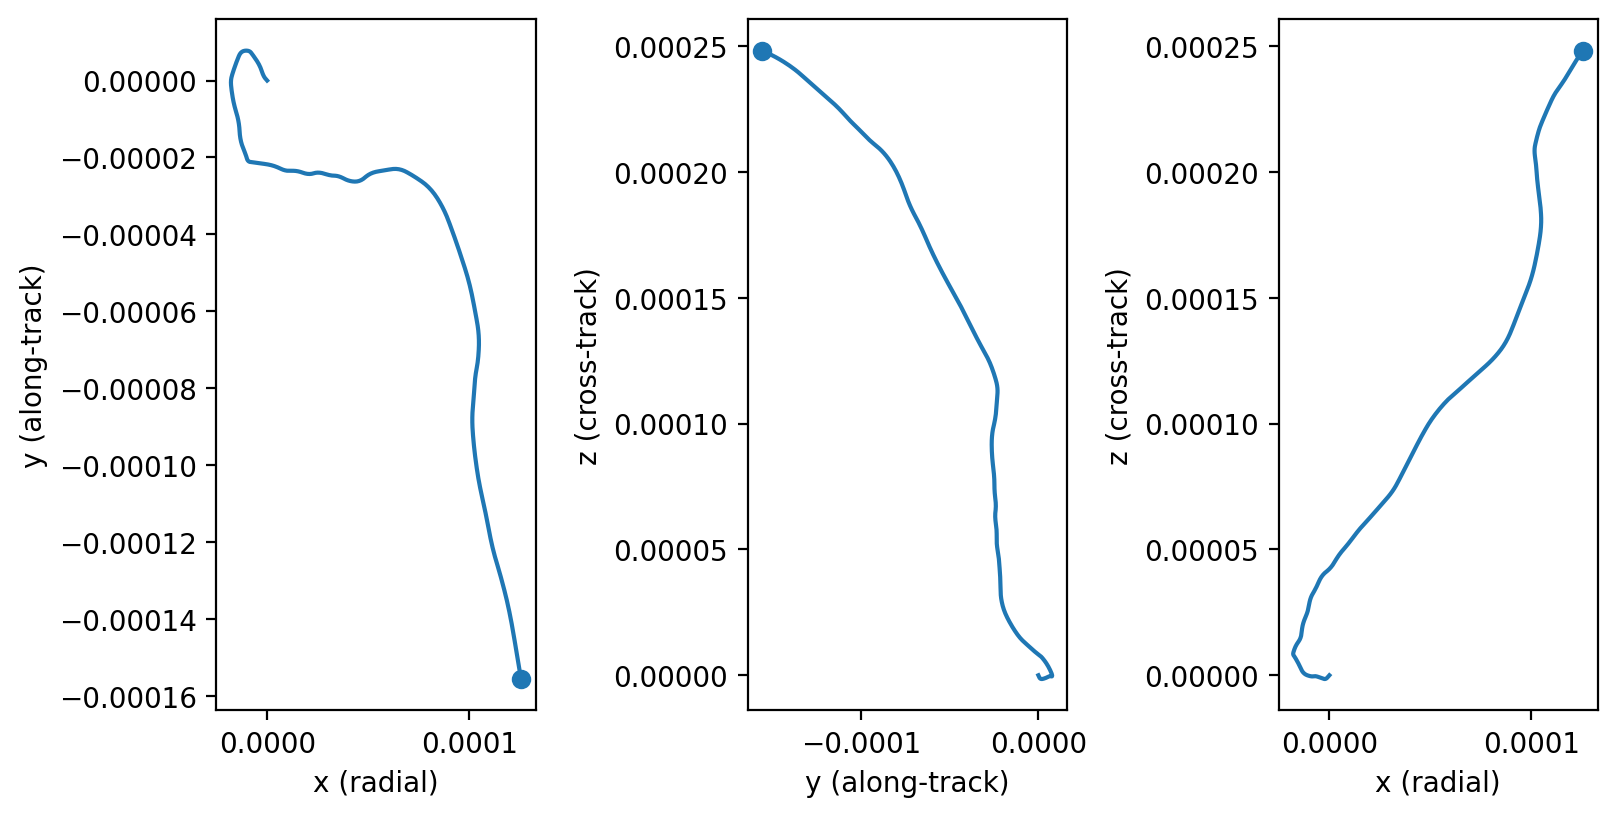

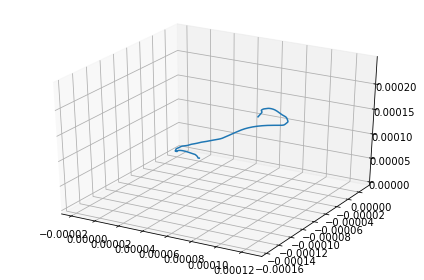

In [6]:
Nctrl = 50  # control steps
control_interval = 10   # apply same ctrl for this step
Nsteps = Nctrl * control_interval

if dt * Nctrl >= tspan_quarter_periods[-1]:
    print("Final Epoch too large!")

t_final = dt * Nsteps

# define control bounds
min_T = -250e-3  # N
max_T = 250e-3 # N

u_min = min_T/MASS_SAT  # m / s
u_max = max_T/MASS_SAT  # m / s

# propagate the state backwards
u_random = ct.rand_box_control(np.ones(Nctrl), u_min, u_max).transpose()  # T x 3
u_mat_rep = np.repeat(u_random, control_interval, axis=0)   # (intervalxT) x 3
u_random_rep = u_mat_rep.flatten()

state_init = np.zeros(6)
states_feasible = np.zeros((6, Nsteps+1))

states_feasible[:,-1] = state_init

for i in range(Nsteps):
    current_t = dt * (Nsteps-i)
    state_init = fd_relative_4T_back(state_init, current_t, u_mat_rep[Nsteps-1-i, :])
    states_feasible[:, Nsteps-1-i] = state_init

print("Initial Condition:", state_init)
ct.plot_control_trajectory(states_feasible)

(501,)


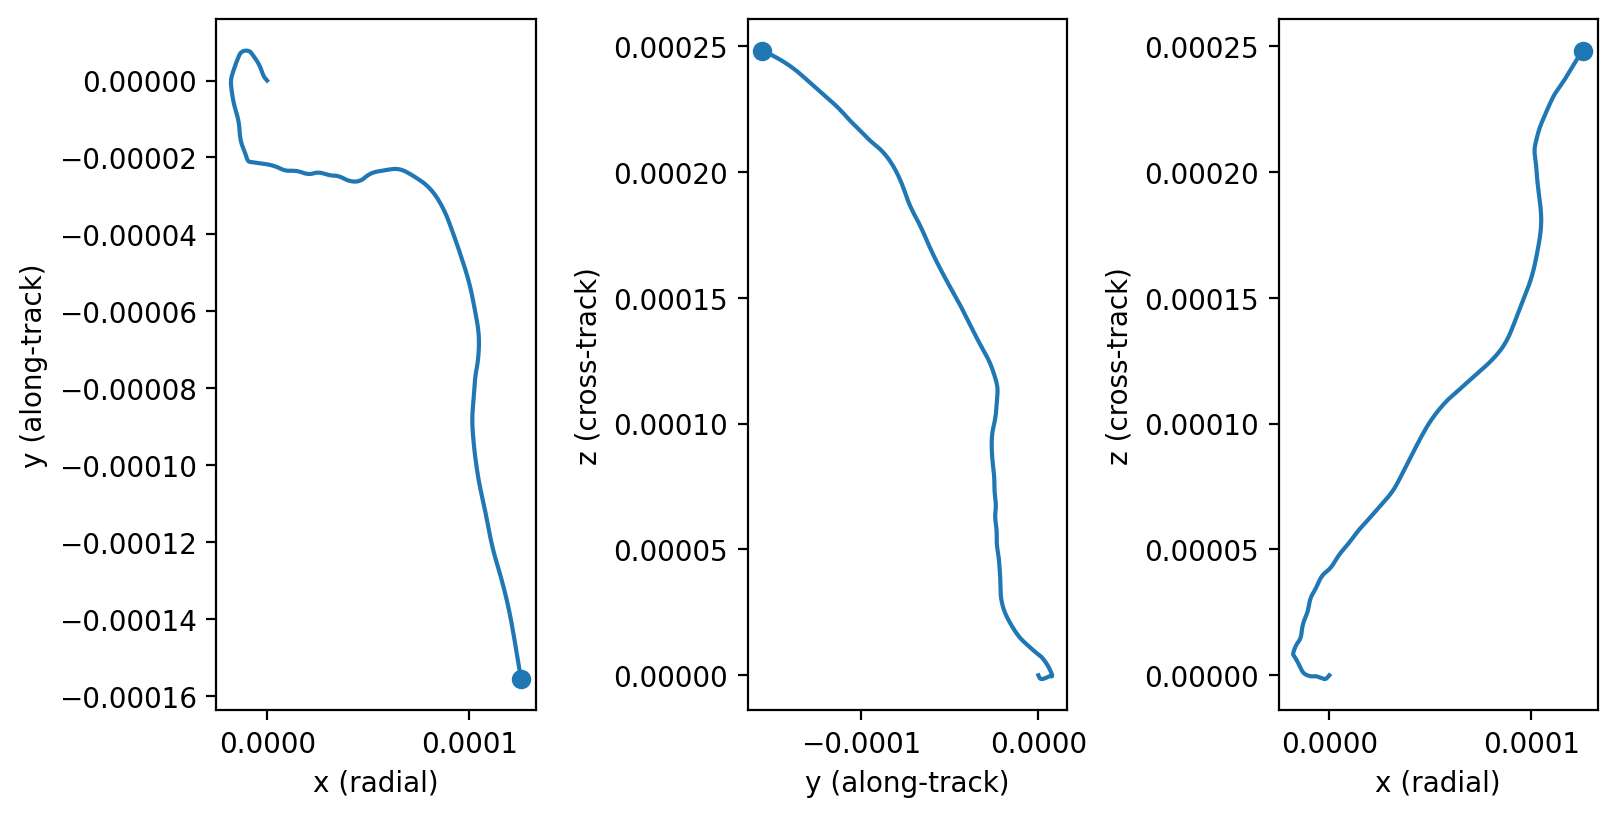

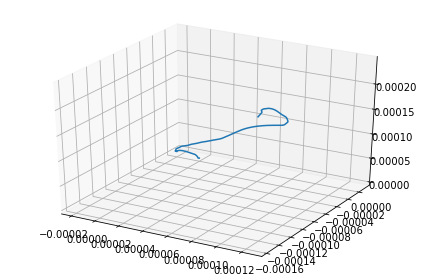

In [7]:
# Forward Propagate the trajectory for check
t_prop = np.arange(0, t_final, dt)
s_forward = ct.propagate_relative_from_control(state_init, u_random_rep, t_prop,  fd_relative_4T)
ct.plot_control_trajectory(s_forward)

In [8]:
modify_initial = False

if modify_initial:
    dr = np.array([1.2e-5, 1.5e-5, 1.3e-5])   # relative position vector to ref
    dv = np.array([1.1e-5, 1.4e-5, 1.7e-5])  # relative velocity to ref
    r0_sat, v0_sat = r0_chief + dr, v0_chief + dv
    x0_sat_eci = jnp.array(np.hstack([r0_sat, v0_sat]))
    state_init = jnp.hstack([dn.eci_to_lvlh(x0_chief_eci, x0_sat_eci)])


## Test Control Optimization with Scipy Optimize

In [9]:
# Test optimizing with scipy minimize
only_mpc = False
final_is_hard_constraint = False   # set terminal constraint as cost or hard constraint

if not only_mpc:
    if final_is_hard_constraint:
        ## Solve with final point as hard constraint
        s_optimal, u_optimal, tspan_optimize, u_initial, cost, constraint_vl \
          = ct.shooting_with_scipy(Nctrl, control_interval,
                                   dt, u_min, u_max, state_init, fd_relative_4T,
                                   u_guess = u_random.flatten(),
                                   maxiter=5000)
    else:
        u_guess = ct.rand_box_control(np.ones(Nsteps), u_min, u_max).transpose().flatten()
        s_optimal, u_optimal, tspan_optimize, u_initial \
          = ct.optimize_with_scipy(Nctrl, control_interval,
                                   dt, u_min, u_max, state_init, fd_relative_4T,
                                   u_guess= None, #u_random.flatten(),
                                   use_MBH = False,
                                   maxiter=5000, stage_w=0, terminal_w=1e10)

    print("Finished!")

Lower bound = -0.0025, Upper bound = 0.0025
T start = 0.0, T end = 49.900000000000006
U example shape = (150,)
initial cost is 15321623327.243282
Zero u cost is  15321623327.243282
Min u cost is   187207962061.3672
Max u cost is   430247906305.951
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          150     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53216D+10    |proj g|=  2.50000D-03

At iterate    1    f=  4.33295D+09    |proj g|=  3.20175D-03

At iterate    2    f=  7.69550D+08    |proj g|=  3.17408D-03

At iterate    3    f=  2.54353D+07    |proj g|=  3.68283D-03

At iterate    4    f=  5.90550D+06    |proj g|=  3.43548D-03

At iterate    5    f=  5.61272D+06    |proj g|=  3.63872D-03

At iterate    6    f=  5.42959D+06    |proj g|=  3.32040D-03

At iterate    7    f=  5.42441D+06    |proj g|=  3.43548D-03

At iterate    8    f=  5.41273D+06    |proj g|=  3.43406D-03

At iterate    9    f=  4.9

## Plot control results
- plot the outputs from the control sequence

(500, 3)
(500,)


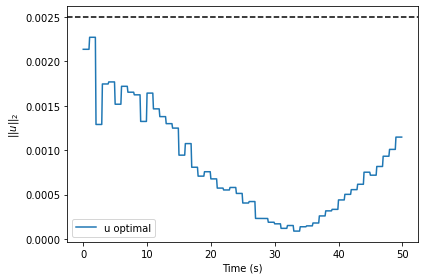

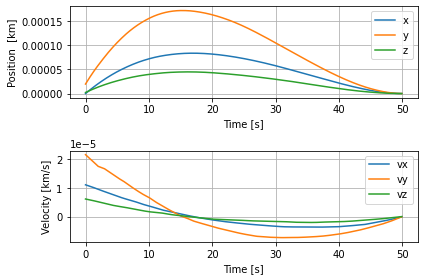

In [20]:
# Plot Result
if not only_mpc:
    print(u_optimal.reshape(-1, 3).shape)
    print(tspan_optimize.shape)

    u_optimal_mat = u_optimal.reshape(-1, 3)
    s_init = ct.propagate_relative_from_control(state_init, u_initial, tspan_optimize, fd_relative_4T)

    # plt.plot(tspan_optimize, np.linalg.norm(u_initial.reshape(-1, 3), axis=1), label="u initial")
    plt.plot(tspan_optimize, np.linalg.norm(u_optimal_mat, axis=1), label="u optimal")
    # plt.plot(tspan_optimize, np.linalg.norm(u_mat_rep, axis=1), label="u feasible")
    plt.xlabel("Time (s)")
    plt.ylabel("$||u||_2$")
    plt.axhline(u_max, c='k', linestyle='--')
    plt.legend()
    plt.tight_layout()
    plt.savefig("Fig/shooting_control.png")
    plt.show()

    dn.plot_relative_orbit(tspan_optimize, s_optimal[:, :-1].T, "shooting",True)

(501,)


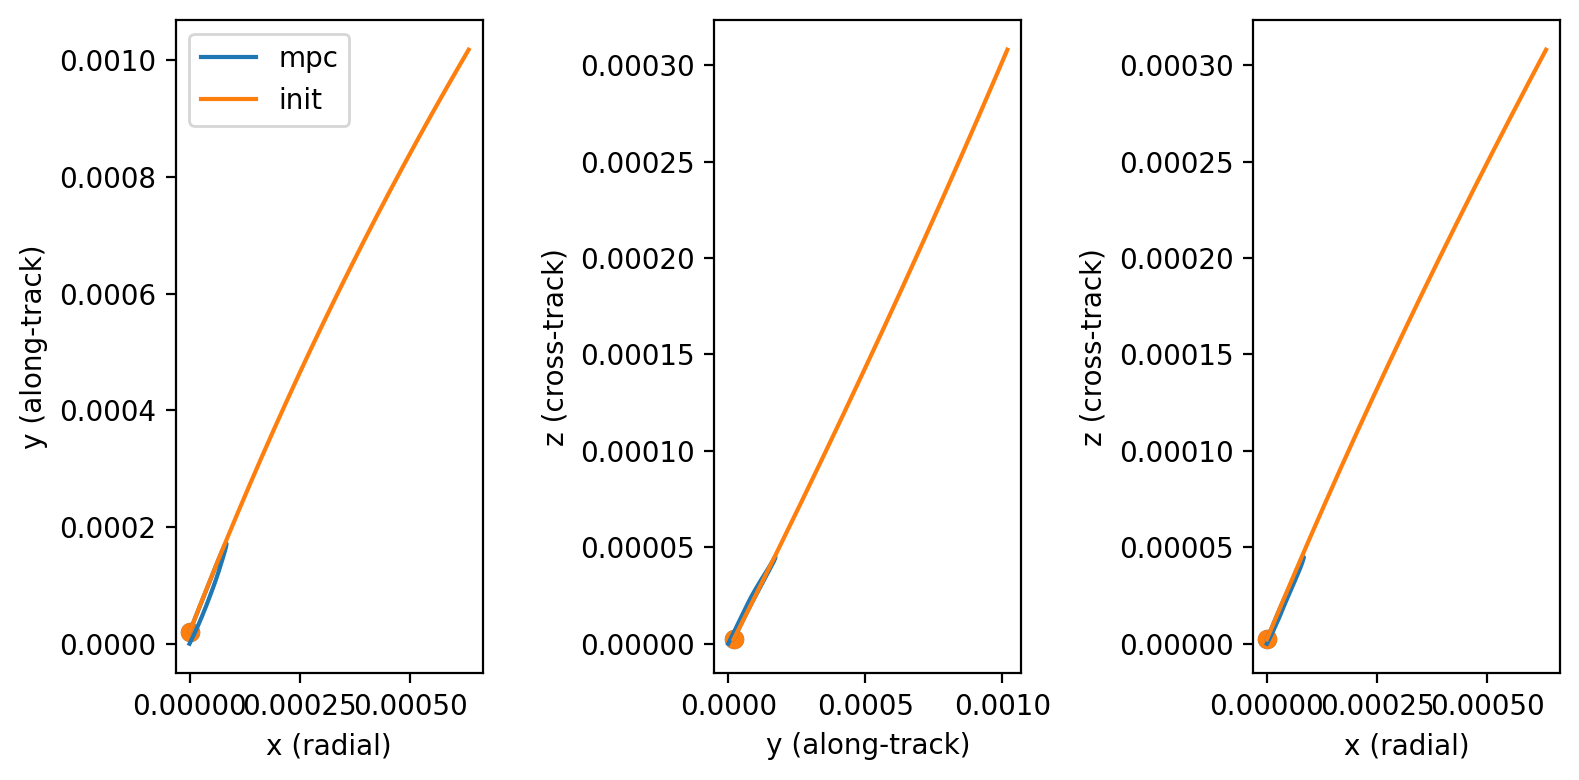

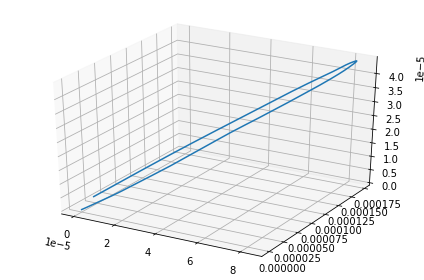

In [11]:
if not only_mpc:
    ct.plot_control_trajectory2(s_optimal, s_init, filelabel="Shooting", is_save=True)

## Try MPC with Scipy Optimize

In [12]:
## Test MPC
P_outer = 1e10 * np.eye(6)                    # terminal state cost matrix
Q_outer = 1e7 * np.eye(6)                    # state cost matrix
rho_outer = 1.                               # trust region parameter
u_max_outer = u_max                  # control effort bound
tol = 5e-1                           # convergence tolerance
max_iters = 10                       # maximum number of scipy optimize
u_dim_outer = 3

N_total_mpc = Nsteps
t_last_mpc = N_total_mpc * dt
N_horizon_mpc = 10

t_mpc, s_mpc, u_mpc = ct.run_MPC_with_scipy(state_init, t_last_mpc, N_horizon_mpc,
                                            P_outer, Q_outer, u_max, rho_outer,
                                            tol, max_iters, u_dim_outer, dt, fd_relative_4T)


t_terminate (50.0) is at index 500 of 510 with value 50.0
final cost: 23309078.02427392
At time 0.0 of 50.0 (index 0 of 500)
------------------------------------------------------------
u_step 2-norm is 0.004330127018922193, 1-norm 0.0075, inf-norm 0.0025
u_max is 0.0025, constraint passed? True and overall False

final cost: 25045580.220130637
At time 0.1 of 50.0 (index 1 of 500)
------------------------------------------------------------
u_step 2-norm is 0.004330127018922193, 1-norm 0.0075, inf-norm 0.0025
u_max is 0.0025, constraint passed? True and overall False

final cost: 26851736.945426494
At time 0.2 of 50.0 (index 2 of 500)
------------------------------------------------------------
u_step 2-norm is 0.004330127018922193, 1-norm 0.0075, inf-norm 0.0025
u_max is 0.0025, constraint passed? True and overall False

final cost: 28723239.460738312
At time 0.30000000000000004 of 50.0 (index 3 of 500)
------------------------------------------------------------
u_step 2-norm is 0.00

Shapes: t=(510,), s=(6, 501), u=(3, 500), norm(u)=(500,)


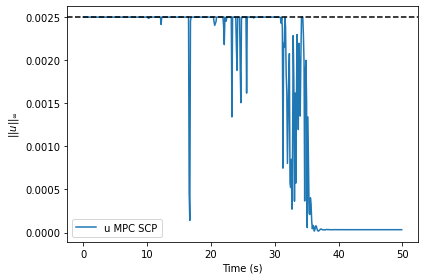

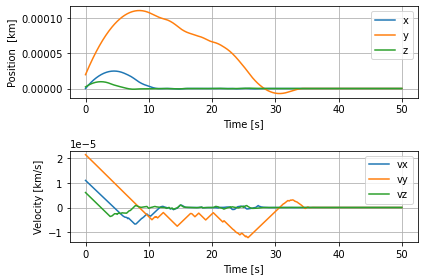

In [13]:
## Plot MPC Result
ct.plot_mpc_control(t_mpc, s_mpc, u_mpc, u_max, filelabel="MPC_SCIPY", is_save=True)

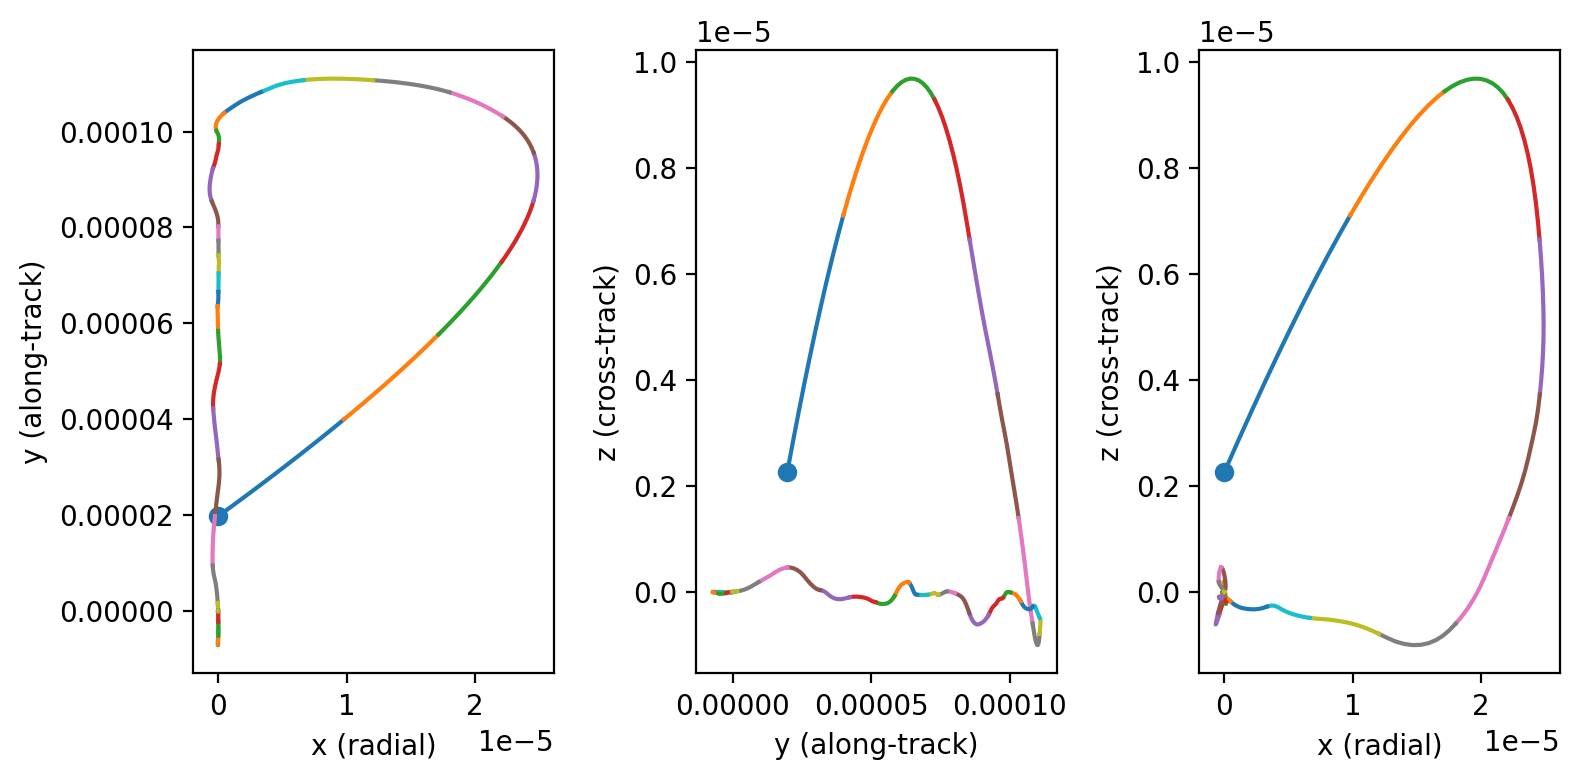

In [14]:
ct.plot_mpc_trajectory(s_mpc, N_total_mpc, N_horizon_mpc,
                       filelabel="MPC_SCIPY", is_save=True)

## Try MPC with CVXPY

In [15]:
do_cvx = False

if do_cvx:
    t_mpc, s_mpc, u_mpc = ct.run_MPC(state_init, t_last_mpc, N_horizon_mpc,
                                     P_outer, Q_outer, u_max, rho_outer,
                                     tol, max_iters, u_dim_outer, dt, fd_relative_4T)

In [16]:
## Plot MPC Result
if do_cvx:
    ct.plot_mpc_control(t_mpc, s_mpc, u_mpc, u_max, filelabel="MPC_CVXPY", is_save=True)

In [17]:
if do_cvx:
    ct.plot_mpc_trajectory(s_mpc, N_total_mpc, N_horizon_mpc,
                       filelabel="MPC_CVXPY", is_save=True)